In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
import experiment as ex

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

file_name = "PLN7.csv"
id_cols =["sample_id"]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/2.00") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\2.00\PLN7


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)
print(f"Dataset shape is {data.shape}")

Dataset shape is (10000, 129)


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")



### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [5]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=50,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

models = {name:RandomNet(input_size=n_features,
                         n_layers=config.n_layers,
                         act_function=config.act_function,
                         n_features = config.n_features,
                         dropout=config.dropout,
                         batch_norm=config.batch_norm,
                         device=device,dtype=torch.float)
          for name, config in configs.items()}
preprocessing = Preprocess_Std()

In [6]:

ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(models,configs,log_dir)

start = datetime.datetime.now()
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores, preds, model_states , train_times, test_times = eval.evaluate(models,dataset,deep_scheme,logger_name="log")

scores_final, preds_final, model_states_ls_final , train_time_deep_final, test_time_deep_final = eval.build(models,dataset,deep_scheme,logger_name="test_log")


Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Training extractors on 4999 instances, validating on 1667 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:31980020.6483(-0.901208),random_3:nan(-0.56051),random_4:nan(-0.510167),random_5:417.9698(-0.980977),random_6:3243202819.9207(-0.279102),random_7:456695.5675(-0.486609),random_8:25606573.1313(-0.303297),random_9:nan(-0.78428),random_10:nan(-0.2731),random_11:nan(-0.943581),random_12:414.1692(-0.360218),random_13:nan(-0.729424),random_14:2677.9525(-0.385566),random_15:nan(-0.286027),random_16:519.2618(-0.862446),random_17:nan(-0.447822),random_18:406.9734(-0.259096),random_19:430.6025(-0.033556),random_20:nan(-0.232474),random_21:529.7974(-0.684561),random_22:nan(-0.111175),random_23:nan(-0.105224),random_24:644.8815(-0.728931),random_25:nan(-0.920616),random_26:397.1519(-0.690395),random_27:nan(-0.305922),random_28:nan(-0.889542),random_29:nan(-0.219165),random_30:458.176(-0.139665),random_31:nan(-0.616

In [7]:
for model, state_dict in model_states_ls_final.items():
     torch.save(state_dict.state(), log_dir / "models" / f"{model}" / f"_final")

summary_logger.info(f"Train times: {train_times}")
summary_logger.info(f"Test times: {test_times}")
ex.save_results(model_states, preds, configs, scores, log_dir,tb)

end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, models, scores)
ex.save_pred_plots(preds, models, log_dir)


Train times: {'fold_0': 3401, 'fold_1': 3392, 'fold_2': 3397, 'fold_3': 3401, 'fold_4': 3378, 'mean': 3393.8}'
Test times: {'fold_0': 2, 'fold_1': 2, 'fold_2': 2, 'fold_3': 2, 'fold_4': 2, 'mean': 2.0}'
Experiments took 6:07:16.435955'
Finished Random Deep Search'
---Loss results---'
0 - random_25 - fold_0:136.0177,fold_1:123.8755,fold_2:145.8139,fold_3:116.3751,fold_4:131.2761,MSE:130.6733,R2:0.7276'
1 - random_38 - fold_0:144.8517,fold_1:129.0535,fold_2:143.7127,fold_3:113.9668,fold_4:123.5043,MSE:131.0208,R2:0.7268'
2 - random_50 - fold_0:134.6028,fold_1:125.9508,fold_2:146.3115,fold_3:116.917,fold_4:134.0698,MSE:131.5718,R2:0.7257'
3 - random_51 - fold_0:138.4926,fold_1:125.9636,fold_2:143.0301,fold_3:118.4875,fold_4:140.0195,MSE:133.1996,R2:0.7223'
4 - random_60 - fold_0:143.328,fold_1:131.3997,fold_2:145.1127,fold_3:119.0302,fold_4:134.2149,MSE:134.619,R2:0.7193'
5 - random_89 - fold_0:158.3337,fold_1:121.5165,fold_2:149.9548,fold_3:116.9077,fold_4:134.4607,MSE:136.2372,R2:0.716'

### Plotting deep results as a function of number of features

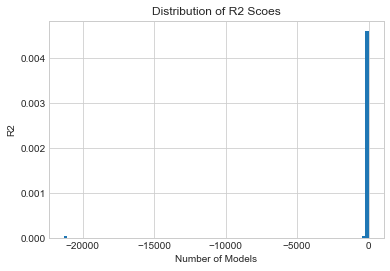

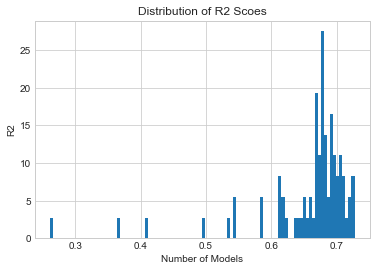

In [8]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores["R2"][name],n_features_dict[name]] for name in scores["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores["R2"][name],n_features_dict[name]] for name in scores["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [9]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val MSE - Val R2 - Test MSE - Test R2")
for i,key in enumerate(sorted(scores['MSE'],key=scores['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores['MSE'][key]} -{scores['R2'][key]} - {scores_final['MSE'][key]} - {scores_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val MSE - Val R2 - Test MSE - Test R2'
0 - random_25 - 130.67330841557765 -0.7275604101791544 - 126.88556460389758 - 0.7363161197584629'
1 - random_38 - 131.0207547983211 -0.7268360223822348 - 134.91316305846607 - 0.7196337783421678'
2 - random_50 - 131.5718385124668 -0.7256870729689289 - 135.37096902413091 - 0.7186824009825676'
3 - random_51 - 133.19958345096967 -0.7222934023811426 - 130.9931346551322 - 0.7277800816925519'
4 - random_60 - 134.6190116518345 -0.7193340494611574 - 130.19694505742922 - 0.7294346620475802'
